In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

datos = pd.read_excel('C:/Users/Noel/Documents/Universidad/4º/2º Cuatri/Trabajo Fin de Grado/TFG_Datos.xlsx', usecols=['Fecha', 'P','G(i)','H_sun','T2m','WS10m','Int'])
#datos = pd.read_csv('C:/Users/Noel/Desktop/TFM/TFG_Datos.csv')
datos

,Fecha,P,G(i),H_sun,T2m,WS10m,Int
0,2017-01-01 00:01,0.0,0.0,0.0,4.59,2.07,0.0
1,2017-01-01 01:01,0.0,0.0,0.0,4.57,2.07,0.0
2,2017-01-01 02:01,0.0,0.0,0.0,4.76,1.93,0.0
3,2017-01-01 03:01,0.0,0.0,0.0,5.34,1.79,0.0
4,2017-01-01 04:01,0.0,0.0,0.0,5.09,1.79,0.0
...,...,...,...,...,...,...,...
35059,2020-12-31 19:01,0.0,0.0,0.0,7.86,4.34,0.0
35060,2020-12-31 20:01,0.0,0.0,0.0,7.75,3.79,0.0
35061,2020-12-31 21:01,0.0,0.0,0.0,7.69,3.24,0.0
35062,2020-12-31 22:01,0.0,0.0,0.0,7.66,3.03,0.0


In [88]:
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M')
datos = datos.set_index('Fecha')
datos = datos.sort_index()
datos.index = datos.index.to_period('T')
# Extraer la hora del índice
datos['hora'] = datos.index.hour
datos['mes'] = datos.index.month
datos.head()

,P,G(i),H_sun,T2m,WS10m,Int,hora,mes
Fecha,,,,,,,,
2017-01-01 00:01,0.0,0.0,0.0,4.59,2.07,0.0,0,1
2017-01-01 01:01,0.0,0.0,0.0,4.57,2.07,0.0,1,1
2017-01-01 02:01,0.0,0.0,0.0,4.76,1.93,0.0,2,1
2017-01-01 03:01,0.0,0.0,0.0,5.34,1.79,0.0,3,1
2017-01-01 04:01,0.0,0.0,0.0,5.09,1.79,0.0,4,1


In [89]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
entrenamiento, validacion, prueba = train_val_test_split(datos)

print(f'Tamaño set de entrenamiento: {entrenamiento.shape}')
print(f'Tamaño set de validación: {validacion.shape}')
print(f'Tamaño set de prueba: {prueba.shape}')


Tamaño set de entrenamiento: (28051, 8)
Tamaño set de validación: (3506, 8)
Tamaño set de prueba: (3507, 8)


In [92]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_train,data_validation,data_test, col_ref):
    '''Escala el dataset utilizando StandardScaler.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo

    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

       # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_train.shape[1]

    # Generar listado con "scalers", 1 por cada covariable de entrada
    scalers = [StandardScaler() for _ in range(NFEATS)]

    # Escalamiento: se usarán todo los parámetros para escalar
    # Escalamiento de los valores de train,val y test
    datos_t = np.zeros(data_train.shape)
    datos_v = np.zeros(data_validation.shape)
    datos_ts = np.zeros(data_test.shape)

    for i, scaler in enumerate(scalers):
 # Escalar datos de entrenamiento
        datos_i = data_train.iloc[:, i].values.reshape(-1, 1)
        datos_t[:, i] = scaler.fit_transform(datos_i).flatten()

        # Escalar datos de validación
        datos_j = data_validation.iloc[:, i].values.reshape(-1, 1)
        datos_v[:, i] = scaler.transform(datos_j).flatten()

        # Escalar datos de prueba
        datos_k = data_test.iloc[:, i].values.reshape(-1, 1)
        datos_ts[:, i] = scaler.transform(datos_k).flatten()

    return datos_t,datos_v,datos_ts, scalers[data_train.columns.get_loc(col_ref)]

# Escalar el dataset con la función anterior
tr, vl, ts, scaler = escalar_dataset(entrenamiento, validacion, prueba, col_ref='P')

# Convertir los resultados a DataFrame
tr = pd.DataFrame(tr, columns=list(datos.columns.values))
vl = pd.DataFrame(vl, columns=list(datos.columns.values))
ts = pd.DataFrame(ts, columns=list(datos.columns.values))


In [5]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    fils, cols = array.shape # Se realiza de esta forma porque se tienen vairas series (multivariado)

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        # Entrada al modelo
        X.append(array[i:i+INPUT_LENGTH,0:cols])

        # Salida (el índice 0 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,0].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 2    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (28025, 24, 8), y_tr: (28025, 2, 1)
Set de validación - x_vl: (3480, 24, 8), y_vl: (3480, 2, 1)
Set de prueba - x_ts: (3481, 24, 8), y_ts: (3481, 2, 1)


c:\Users\Noel\Desktop\TFM\TensorFlow_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step
Índices de ventanas con outliers (Autoencoder): [ 2268  2583  2584  2585  2586  2587  2588  2589  2590  2591  2592  2593
  2594  2595  2596  2597  2598  2599  2600  2601  2602  2603  2604  2605
  2606  2607  2608  2609  2610  2611  2612  2613  2614  2615  2616  2617
  2618  2619  2620  2621  2622  2623  2624  2625  2626  2627  2628  2798
  2799  2800  2801  2802  2803  2804  2805  2806  2807  2808  2809  2810
  2811  2812  2813  2814  2815  2816  2817  2818  2819  2820  2821  2822
 10119 10120 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131
 10132 10133 10134 10135 10136 10137 10138 11510 11511 11512 11513 11514
 11515 11516 11517 11518 11519 11520 11521 11522 11523 11524 11525 11526
 11527 11528 11529 11530 11531 11703 11704 11705 11706 11707 11708 11709
 11710 11711 11712 11713 11714 11715 11716 11717 11718 11719 11720 11721
 11722 11723 11724 11725 11726 11727 11740 19384 19385 19386 19387 19388
 19389 19390 19391 19392 19393 19

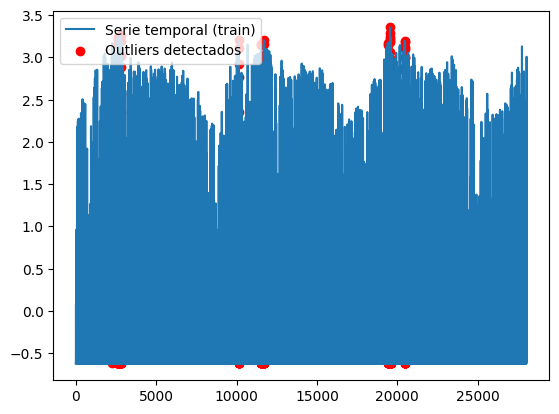

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

window_size = 24  # Tamaño de la ventana para el autoencoder

# Autoencoder simple (input = output)
autoencoder = Sequential([
    Dense(8, activation='relu', input_shape=(window_size,)),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(window_size, activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='mse')

# Prepara las ventanas para el autoencoder
def create_windows(series, window_size):
    X = []
    for i in range(len(series) - window_size + 1):
        X.append(series[i:i+window_size])
    return np.array(X)

# Usar la columna 'P' del set de entrenamiento escalado
P_train = tr['P'].values
X_windows = create_windows(P_train, window_size)

# Entrenar el autoencoder
autoencoder.fit(X_windows, X_windows, epochs=50, batch_size=16, verbose=0)

# Reconstrucción y error
X_pred = autoencoder.predict(X_windows)
mse = np.mean(np.power(X_windows - X_pred, 2), axis=1)

# Umbral para detectar outliers (p.ej. 95 percentil)
threshold = np.percentile(mse, 99)
outliers = np.where(mse > threshold)[0]

print("Índices de ventanas con outliers (Autoencoder):", outliers)

# Visualización
plt.plot(P_train, label='Serie temporal (train)')
outlier_indices = outliers + window_size // 2
# Asegura que los índices estén dentro del rango
outlier_indices = outlier_indices[outlier_indices < len(P_train)]
plt.scatter(outlier_indices, P_train[outlier_indices], color='red', label='Outliers detectados')
plt.legend()
plt.show()

Índices de ventanas con outliers (Isolation Forest): [ 1724  1795  1798 ... 23398 23422 23494]


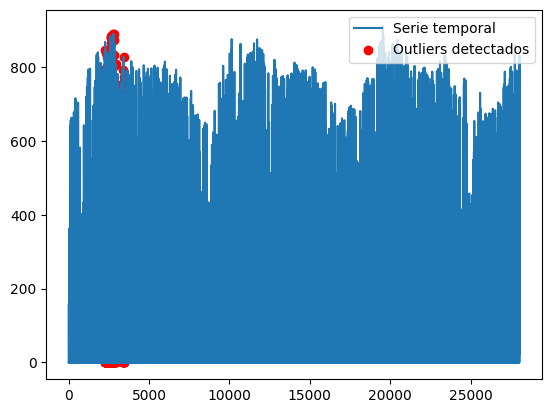

In [91]:
from sklearn.ensemble import IsolationForest
window_size = 24  # Tamaño de la ventana para el modelo Isolation Forest
# Modelo Isolation Forest sobre la media de 'P' en cada ventana
def create_windows(data, size):
    X = []
    for i in range(len(data) - size):
        X.append(data[i:i+size])
    return np.array(X)

X = create_windows(entrenamiento['P'], window_size)
P_windows = X
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(P_windows)
preds = model.predict(P_windows)  # -1 = outlier, 1 = normal

outliers = np.where(preds == -1)[0]

print("Índices de ventanas con outliers (Isolation Forest):", outliers)

# Visualización
plt.plot(entrenamiento.iloc[:, 0].values, label='Serie temporal')
outlier_indices = outliers + window_size // 2
# Asegura que los índices estén dentro del rango
outlier_indices = outlier_indices[outlier_indices < len(ts)]
plt.scatter(outlier_indices, entrenamiento['P'].values[outlier_indices], color='red', label='Outliers detectados')
plt.legend()
plt.show()

In [31]:
import pandas as pd
scores = model.decision_function(X)
# Crear tabla simple con índice y valor
outlier_table = pd.DataFrame({
    'Índice': outlier_indices,
    'Valor': entrenamiento['P'].values[outlier_indices],
    'Anomaly Score': scores[outlier_indices]
})

print(outlier_table.head())


   Índice   Valor  Anomaly Score
0    1736  217.18       0.011985
1    1807   12.99       0.018367
2    1810  636.43       0.033938
3    1818   17.79       0.013901
4    2218  652.36       0.030408


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
# Parámetros
num_layers = 3  # Número variable de capas LSTM
units = [64,32,12]      # Número de neuronas

# Usar los valores correctos para input_shape según tus datos
input_shape = (x_tr.shape[1], x_tr.shape[2])

# Crear modelo secuencial
model = Sequential()

# Añadir la primera capa LSTM (requiere input_shape)
model.add(LSTM(units[0], return_sequences=(num_layers > 1), input_shape=input_shape))

# Añadir capas intermedias (si las hay)
for i,neurons in zip(range(1, num_layers - 1), units[1:-1]):
    model.add(LSTM(neurons, return_sequences=True))

# Añadir la última capa LSTM (sin return_sequences)
if num_layers > 1:
    model.add(LSTM(units[-1]))

# Capa de salida
model.add(Dense(OUTPUT_LENGTH))  # Por ejemplo, para regresión

# Compilar
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=1e-4),  # Optimizer Adam con learning rate = 1e-4
    metrics=['mse', 'mae', 'mape']
)


c:\Users\Noel\Desktop\TFM\TensorFlow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = model.fit(
    x = x_tr,
    y = y_tr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl, y_vl),
    verbose=2,
)

Epoch 1/100
219/219 - 7s - 31ms/step - loss: 0.6567 - mae: 0.6143 - mape: 162.5674 - mse: 0.6567 - val_loss: 0.3791 - val_mae: 0.4313 - val_mape: 329.9984 - val_mse: 0.3791
Epoch 2/100
219/219 - 4s - 17ms/step - loss: 0.2881 - mae: 0.3530 - mape: 169.6941 - mse: 0.2881 - val_loss: 0.2824 - val_mae: 0.3363 - val_mape: 246.3745 - val_mse: 0.2824
Epoch 3/100
219/219 - 4s - 17ms/step - loss: 0.2415 - mae: 0.3031 - mape: 159.4557 - mse: 0.2415 - val_loss: 0.2505 - val_mae: 0.3039 - val_mape: 264.8655 - val_mse: 0.2505
Epoch 4/100
219/219 - 4s - 16ms/step - loss: 0.2149 - mae: 0.2746 - mape: 156.9452 - mse: 0.2149 - val_loss: 0.2226 - val_mae: 0.2800 - val_mape: 240.7335 - val_mse: 0.2226
Epoch 5/100
219/219 - 3s - 16ms/step - loss: 0.1965 - mae: 0.2547 - mape: 151.5843 - mse: 0.1965 - val_loss: 0.2088 - val_mae: 0.2636 - val_mape: 224.0410 - val_mse: 0.2088
Epoch 6/100
219/219 - 3s - 16ms/step - loss: 0.1839 - mae: 0.2410 - mape: 145.9681 - mse: 0.1839 - val_loss: 0.1976 - val_mae: 0.2516 -

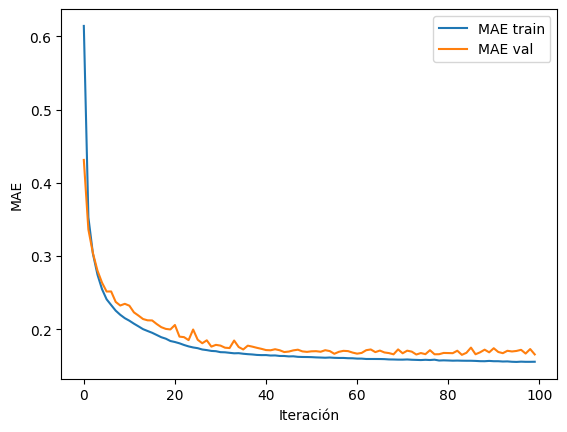

In [18]:
plt.plot(historia.history['mae'],label='MAE train')
plt.plot(historia.history['val_mae'],label='MAE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

In [19]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [23]:
hpredic=168
a=x_ts[:hpredic]
pred=predecir(a, model, scaler)
t1 = np.array([])  # Inicializar t1 como un array vacío
t2 = np.array([])  # Inicializar t2 como un array vacío
real = np.array([])  # Inicializar t2 como un array vacío
for i in range(hpredic):
  if i%2 == 0:
    t1= np.concatenate((t1, [pred[i]]))
  else:
    t2=np.concatenate((t2, [pred[i]]))

y_real = y_ts[:168]

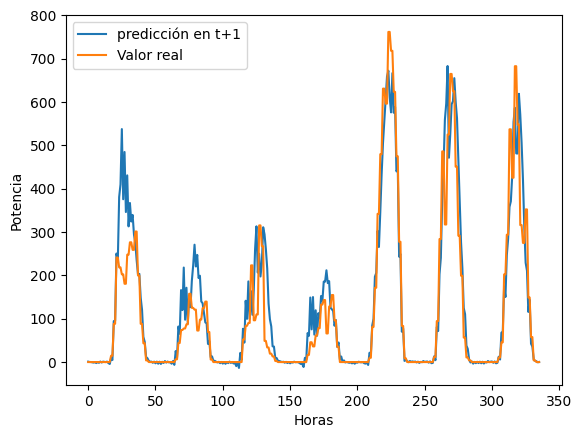

In [24]:
 t1=np.concatenate((t1, [0]))
 t2=np.concatenate(([0], t2))
plt.plot(pred,label='predicción en t+1')
plt.plot(scaler.inverse_transform(y_real[:hpredic].reshape(-1, 1)).reshape(-1),label='Valor real')
plt.xlabel('Horas')
plt.ylabel('Potencia')
plt.legend();